# Levenshtein distance
Mateusz Wojtulewicz

In [114]:
import json
import tqdm
import requests

from pathlib import Path

## 1. Use the corpus from exercise no. 1.
## 2. Make sure the text in the corpus does not contain HTML code.
## 3. Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus.

I'm loading a pretrained polish pipeline from SpaCy. Then I'm extracting its tokenizer.

In [16]:
import spacy

In [17]:
nlp = spacy.load("pl_core_news_sm")
tokenizer = nlp.tokenizer

Example of tokenizer in action.

In [18]:
from spacy.lang.pl.examples import sentences

tokenizer = nlp.tokenizer
doc = tokenizer(sentences[0])

print(doc.text)

for token in doc:
    print(token.text)

Poczuł przyjemną woń mocnej kawy.
Poczuł
przyjemną
woń
mocnej
kawy
.


In [19]:
tokenized_acts = {}

acts_dir = Path("../data/ustawy/")
n_acts = len(list(acts_dir.iterdir()))

for act in tqdm.tqdm(acts_dir.iterdir(), desc="Tokenizing acts", total=n_acts):
    act_id = act.stem
    content = act.read_text(encoding="utf8")
    tokens = tokenizer(content)
    tokenized_acts[act_id] = [token.text.lower() for token in tokens]

Tokenizing acts: 100%|██████████| 1179/1179 [00:36<00:00, 31.96it/s]


## 4. Compute a **frequency list** for each of the processed files.

In [29]:
from collections import Counter

In [30]:
frequency_list_per_act = {
    act_id: Counter(tokens)
    for act_id, tokens in tqdm.tqdm(
        tokenized_acts.items(), desc="Calculating frequency lists", total=n_acts
    )
}

Calculating frequency lists: 100%|██████████| 1179/1179 [00:00<00:00, 2303.61it/s]


In [40]:
for act_id, counter in list(frequency_list_per_act.items())[:10]:
    print(f"{act_id}: {counter.most_common(5)}")

1993_599: [('|', 1634), ('-', 858), ('\n', 561), ('.', 497), ('   ', 485)]
1993_602: [('.', 155), (',', 89), ('w', 63), ('"', 44), ('\n          ', 36)]
1993_645: [('.', 23), (',', 7), ('\n', 7), ('z', 6), ('r', 6)]
1993_646: [('.', 688), (',', 610), ('w', 506), ('-', 324), ('"', 304)]
1994_150: [('.', 20), (',', 6), ('w', 6), ('z', 5), ('i', 4)]
1994_195: [('.', 2724), (',', 2197), ('\n  ', 1368), ('w', 1226), ('\n', 1117)]
1994_201: [('.', 36), (',', 19), ('\n                ', 19), ('i', 9), ('z', 8)]
1994_214: [('.', 17), ('\n', 5), ('w', 4), ('"', 4), ('z', 3)]
1994_215: [('.', 39), (',', 23), ('w', 14), ('z', 8), ('\n       ', 8)]
1994_288: [(',', 26), ('.', 23), ('w', 17), (')', 16), ('\n', 11)]


## 5. Aggregate the result to obtain one global frequency list.

In [42]:
all_tokens = [token for tokens in tokenized_acts.values() for token in tokens]
frequency_list = Counter(all_tokens)

print(f"Most frequent tokens: {frequency_list.most_common(5)}")

Most frequent tokens: [('.', 437694), (',', 341126), ('w', 201224), ('\n', 181703), (')', 100194)]


## 6. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).

I'm using a Token's property `is_alpha` which is `True` if the token consists of alphabetic characters. As shown below, it includes Polish diacritics.

In [49]:
tokenizer("żółć")[0].is_alpha

True

In [47]:
tokens_filtered = [
    token
    for token in tqdm.tqdm(all_tokens, desc="Filtering tokens", total=len(all_tokens))
    if tokenizer(token)[0].is_alpha and len(token) > 1
]

Filtering tokens: 100%|██████████| 5833029/5833029 [00:30<00:00, 193085.36it/s]


In [61]:
frequency_list = Counter(tokens_filtered)

Most frequent tokens.

In [62]:
frequency_list.most_common(10)

[('art', 83804),
 ('do', 60735),
 ('ust', 53636),
 ('na', 50647),
 ('się', 45886),
 ('lub', 45800),
 ('poz', 45224),
 ('nr', 44950),
 ('oraz', 33558),
 ('mowa', 28783)]

## 7. Make a plot in a logarithmic scale [...]

In [50]:
import matplotlib.pyplot as plt

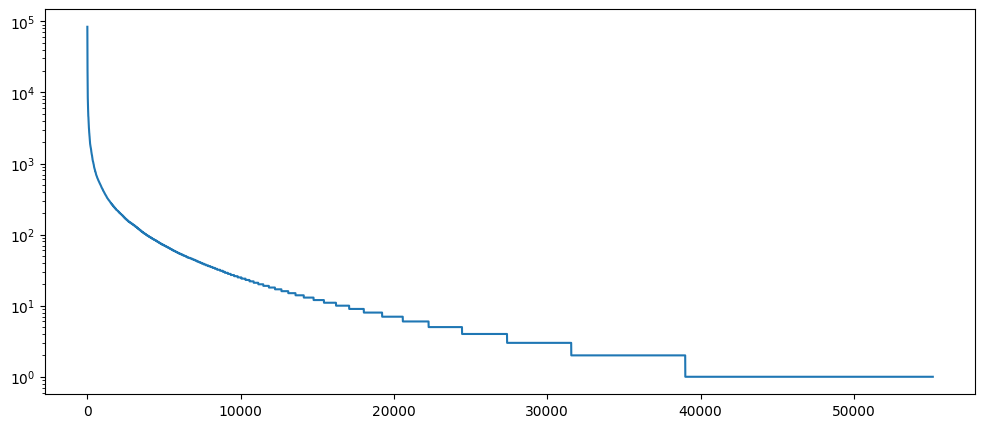

In [55]:
frequency_list_ranked = sorted(frequency_list.items(), key=lambda item: (item[1], item[0]), reverse=True)
counts = [count for token, count in frequency_list_ranked]

plt.figure(figsize=(12,5))
plt.plot(counts)
plt.yscale("log")

## 8. Install Morfeusz (Binding dla Pythona) and use it to find all words that do not appear in that dictionary.

I'm instantiating Morfeusz with `agglutination` option set to `isolated` because I will be analysing text previously segmented by SpaCy.

In [130]:
import morfeusz2

morf = morfeusz2.Morfeusz(aggl="isolated")

I'm using `analyse` method to determine proposed tags for every word and then I treat words tagged with `ign` (ignored) as not present in the dictionary.

In [132]:
morf.analyse("Abcd znalazł się.")

[(0, 1, ('Abcd', 'Abcd', 'ign', [], [])),
 (1, 2, ('znalazł', 'znaleźć', 'praet:sg:m1.m2.m3:perf', [], [])),
 (2, 3, ('się', 'się', 'part', [], [])),
 (3, 4, ('.', '.', 'interp', [], []))]

In [133]:
def is_unknown(word: str) -> bool:
    n1, n2, (word, base, tag, _, _) = morf.analyse(word)[0]
    return tag == "ign"

words_unknown = [
    (word, count)
    for (word, count) in frequency_list.items()
    if is_unknown(word=word)
]

In [137]:
words_unknown = sorted(words_unknown, key=lambda item: item[1], reverse=True)

words_unknown[::300]

[('późn', 1065),
 ('msv', 4),
 ('denodimo', 2),
 ('ustanowiewniu', 1),
 ('sust', 1),
 ('uzależnion', 1),
 ('nektarowania', 1),
 ('ism', 1),
 ('fenyloaminopropylo', 1)]

## 9. Find 30 words with the highest ranks that do not belong to the dictionary.

In [231]:
words_unknown_most = words_unknown[:30]
words_unknown_most

[('późn', 1065),
 ('gmo', 298),
 ('sww', 216),
 ('skw', 196),
 ('ex', 167),
 ('ike', 162),
 ('remediacji', 120),
 ('ure', 103),
 ('uke', 97),
 ('kn', 95),
 ('cn', 83),
 ('pkwiu', 81),
 ('udt', 77),
 ('bswsg', 70),
 ('bswp', 66),
 ('biobójczych', 63),
 ('phs', 53),
 ('hcfc', 44),
 ('fep', 42),
 ('mgo', 41),
 ('utk', 40),
 ('frd', 36),
 ('ron', 35),
 ('uokik', 35),
 ('doke', 34),
 ('cbśp', 34),
 ('pcn', 32),
 ('vitro', 32),
 ('haccp', 32),
 ('iia', 31)]

## 10. Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [145]:
words_unknown_5 = [(word, count) for word, count in words_unknown if count == 5][:30]
words_unknown_5

[('wapnio', 5),
 ('instrumen', 5),
 ('vista', 5),
 ('próbobiorców', 5),
 ('rci', 5),
 ('betezda', 5),
 ('swine', 5),
 ('contagious', 5),
 ('teryto', 5),
 ('rialnego', 5),
 ('szcze', 5),
 ('jed', 5),
 ('tów', 5),
 ('agave', 5),
 ('inci', 5),
 ('nym', 5),
 ('denitracyjne', 5),
 ('odgazowywacze', 5),
 ('rr', 5),
 ('cznika', 5),
 ('zawart', 5),
 ('ośc', 5),
 ('ami', 5),
 ('ym', 5),
 ('organicz', 5),
 ('chelatującym', 5),
 ('najmnie', 5),
 ('urt', 5),
 ('kpwig', 5),
 ('gj', 5)]

## 11. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from lists defined in points 8 and 9. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

I'm using Levenshtein automaton to effectively find corrections. It is doing up to 2 edits.

In [209]:
KNOWN_WORDS = {
    word: count 
    for word, count in frequency_list.items()
    if not is_unknown(word)
}

def rank(word: str) -> int:
    """Rank of `word`."""
    return KNOWN_WORDS[word]

def corrections(word: str, n: int = 1, d: int = 1) -> str:
    "Returns `n` most ranked spelling corrections for word with Lavenhstein distance not greater than `d`."
    return sorted(candidates(word=word, d=d), key=rank)[:n]

def candidates(word:str, d: int) -> set: 
    "Generate all possible spelling corrections with Lavenhstein distance not greater than `d`."
    candidates = {word}
    for i in range(d):
        edits = (edits_one(c) for c in candidates)
        candidates = candidates.union(*edits)
    return known(candidates)

def known(words) -> set: 
    "The subset of `words` that appear in the dictionary of KNOWN_WORDS."
    return set(w for w in words if w in KNOWN_WORDS)

def edits_one(word: str) -> set:
    "All edits that are one edit away from `word` (in polish language)."
    letters    = 'aąbcćdeęfghijklłmnoópqrsśtuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

In [211]:
corrections("konsttucja", d=2, n=5)

['konstytucję', 'konstytucja', 'konstrukcja', 'konstytucją', 'konstytucji']

I've found that searching for corrections with Lavenhstein distance greater than 2 takes a lot of computational time, so I decided to limit it to two possible edits.

Corrections for list defined in point 9:

In [232]:
for word, count in words_unknown_most:
    corrs = corrections(word=word, d=2, n=5)
    corrs_str = ", ".join(corrs)
    print(f"Word: {word: <11} [count: {count: >4}] -> corrections: {corrs_str}")

Word: późn        [count: 1065] -> corrections: paź, płyn, pn, pół, pln
Word: gmo         [count:  298] -> corrections: who, ho, mk, dma, ghz
Word: sww         [count:  216] -> corrections: ws, sie, spp, łów, ow
Word: skw         [count:  196] -> corrections: mk, skal, ow, sg, stp
Word: ex          [count:  167] -> corrections: at, mem, mk, ow, sg
Word: ike         [count:  162] -> corrections: mk, wek, ilo, pte, iłu
Word: remediacji  [count:  120] -> corrections: mediacji
Word: ure         [count:  103] -> corrections: turą, ar, turę, hurt, pte
Word: uke         [count:   97] -> corrections: sie, uli, mk, umie, uw
Word: kn          [count:   95] -> corrections: kal, at, mk, ow, fan
Word: cn          [count:   83] -> corrections: at, mk, ow, fan, ocz
Word: pkwiu       [count:   81] -> corrections: piwie, kwitu
Word: udt         [count:   77] -> corrections: et, at, usta, ddt, itd
Word: bswsg       [count:   70] -> corrections: 
Word: bswp        [count:   66] -> corrections: stp, spp, 

Corrections for list defined in point 10:

In [233]:
for word, count in words_unknown_5:
    corrs = corrections(word=word, d=2, n=5)
    corrs_str = ", ".join(corrs)
    print(f"Word: {word: <13} -> corrections: {corrs_str}")

Word: wapnio        -> corrections: wapni, walnie, waniu, wanie, wapniowe
Word: instrumen     -> corrections: instrument, instrumentu, instrumenty
Word: vista         -> corrections: dosta, usta, cięta, niska, pusta
Word: próbobiorców  -> corrections: 
Word: rci           -> corrections: rol, ocz, ról, eli, nic
Word: betezda       -> corrections: 
Word: swine         -> corrections: sie, sile, śwince, sanie, zwie
Word: contagious    -> corrections: 
Word: teryto        -> corrections: tery
Word: rialnego      -> corrections: ratalnego, finalnego, pilnego, realnego, zdalnego
Word: szcze         -> corrections: moszcze, szczuje, szczyt, szczerą, szcza
Word: jed           -> corrections: mem, mid, wek, ef, et
Word: tów           -> corrections: ow, kitów, ról, stój, tęp
Word: agave         -> corrections: agar, agape
Word: inci          -> corrections: nicz, winni, nfi, nic, pni
Word: nym           -> corrections: nap, rys, mem, nów, nysa
Word: denitracyjne  -> corrections: 
Word: odgazow

## 12. Load SGJP dictionary (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) and use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [240]:
# helper function
def pprint(response: requests.Response | dict | list):
    if isinstance(response, requests.Response):
        response = response.json()
    print(json.dumps(response, indent=4, ensure_ascii=False))

Connecting to Elasticsearch.

In [249]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import parallel_bulk

In [241]:
es_url = "http://localhost:9200"

In [252]:
es = Elasticsearch(es_url)

pprint(es.info().body)

{
    "name": "b40d2515d547",
    "cluster_name": "docker-cluster",
    "cluster_uuid": "U5o6JseNQMWv_ouTF8lKYA",
    "version": {
        "number": "8.4.3",
        "build_flavor": "default",
        "build_type": "docker",
        "build_hash": "42f05b9372a9a4a470db3b52817899b99a76ee73",
        "build_date": "2022-10-04T07:17:24.662462378Z",
        "build_snapshot": false,
        "lucene_version": "9.3.0",
        "minimum_wire_compatibility_version": "7.17.0",
        "minimum_index_compatibility_version": "7.0.0"
    },
    "tagline": "You Know, for Search"
}


Creating new index.

In [253]:
response = es.indices.create(
    index="words", 
    mappings={
        "properties": {
            "content": {
                "type": "text",
                "analyzer": "keyword"
            }
        }
    }
).body

pprint(response)

{
    "acknowledged": true,
    "shards_acknowledged": true,
    "index": "words"
}


Indexing dictionary words.

In [258]:
lines = Path("../data/sgjp.tab").read_text(encoding="utf8").split("\n")[:-1]

In [259]:
def gen_actions():
    index_name = "words"
    for i, line in enumerate(lines):
        word, base, tag, _, _ = line.split("\t")
        doc = {
            '_op_type': 'create',
            '_index': index_name,
            '_id': i,
            'content': word
        }
        yield doc

In [260]:
progress = tqdm.tqdm(desc="Indexing words", total=len(lines))

for ok, action in parallel_bulk(client=es, actions=gen_actions()):
    progress.update(1)

## 13. Compare the results of your algorithm and output of ES.

For list defined in pint 9:

In [273]:
for word, count in words_unknown_most:
    response = requests.get(
        url=f"{es_url}/words/_search",
        json={
            "query": {
                "match": {
                    "content": {
                        "query": word,
                        "fuzziness": 2
                    }
                }
            }
        }
    ).json()
    corrs = [hit["_source"]["content"] for hit in response["hits"]["hits"]]
    corrs_str = ", ".join(corrs)
    print(f"Word: {word: <11} -> corrections: {corrs_str}")
    

Word: późn        -> corrections: późni, późno, późna, późna, późne, późne, późne, późne, późni, późno
Word: gmo         -> corrections: dmo, emo, emo, emo, emo, emo, emo, emo, emo, emo
Word: sww         -> corrections: siw, sów, suw, swa, swe, swe, swe, swe, swą, swą
Word: skw         -> corrections: sakw, siw, ska, ski, sków, sów, suw, kw, Lów, Lew
Word: ex          -> corrections: Rex, em, eś, ee, ef, ef, eh, ej, el, em
Word: ike         -> corrections: Mike, Mike, Mike, Nike, Mike, ile, ile, ile, ile, ile
Word: remediacji  -> corrections: repudiacji, repudiacji, repudiacji, remediach, remediami, mediacji, mediacji, mediacji
Word: ure         -> corrections: Sure, bure, bure, bure, bure, Bure, Bure, źre, użre, uje
Word: uke         -> corrections: uje, ule, Ale, Ale, Age, Ale, Ale, Bek, Bek, Buce
Word: kn          -> corrections: on, on, on, ka, kan, kb, ka, ki, kin, ku
Word: cn          -> corrections: ce, cen, ck, ck, ck, ck, ck, ck, ck, ck
Word: pkwiu       -> corrections: pawiu,

For list defined in pint 10:

In [274]:
for word, count in words_unknown_5:
    response = requests.get(
        url=f"{es_url}/words/_search",
        json={
            "query": {
                "match": {
                    "content": {
                        "query": word,
                        "fuzziness": 2
                    }
                }
            }
        }
    ).json()
    corrs = [hit["_source"]["content"] for hit in response["hits"]["hits"]]
    corrs_str = ", ".join(corrs)
    print(f"Word: {word: <13} -> corrections: {corrs_str}")

Word: wapnio        -> corrections: wapnic, wapnico, wapnij, wapnią, wapnić, wapnię, wapnił, wapnił, wapniło, wapniło
Word: instrumen     -> corrections: instrument, instrumentu, instrumenty
Word: vista         -> corrections: lista, wista, visa, Liska, Liska, Lisna, Lisna, Lissa, Listka, Liszta
Word: próbobiorców  -> corrections: pracobiorców, prądobiorców
Word: rci           -> corrections: Irci, Irci, Irci, rai, rai, rai, rai, rai, rai, raci
Word: betezda       -> corrections: etezja
Word: swine         -> corrections: swing, swing, swing, swing, sine, sine, sine, sine, Kwice, Kwice
Word: contagious    -> corrections: 
Word: teryto        -> corrections: teryno, Moryto, Moryto, Moryto, Pereto, Pereto, Perygo, Perygo, Peryta, Wereto
Word: rialnego      -> corrections: realnego, realnego, Piasnego, Skalnego, analnego, analnego, arealnego, arealnego, atrialnego, atrialnego
Word: szcze         -> corrections: czcze, czcze, czcze, czcze, sucze, sucze, sicze, sucze, sucze, sucze
Word: jed

## 14. Draw conclusions regarding:

### The distribution of words in the corpus.
The corpus contains words in limited forms because of the nature of formal acts. Words with most occurences are redactional units, which is not suprising. 

### The number of true misspellings vs. the number of unknown words.
Within 30 unknown words with the most occurrences appear words that do not exist (eq. `biobójczych`), words that are hardly identifiable as a misspelled, but rather an abbreviation (eq. `kn`, `cn`), words that are probably a splitted word (eq. `vitro`, `późn`). Misspellings can also be found in the other list. Words such as `najmnie` or `instrumen` are probably misspelled `najmniej` and `instrument`. In this list splitted words can be found as well: `cznika`, `teryto`, `rialnego`. Unknown word can be english word used in the polish corpus, such as `contagious`.

### The performance of your method compared to ElasitcSearch.
Elasticsearch outperfored my automaton method in case of time. It was almost instantaneous, while my method took about 2s. This is because ES uses indexed data and clever searching, while my method creates every possible word in a given Levenshtein distance.

### The results provided by your method compared to ElasticSearch. The validity of the obtained corrections.
ES results contain more general corrections, because it used every word from PJN dictionary. My method creates a word base from provided corpus which, for obvious reasons, does not contain so many different words.

ES results are much more general and universal. But my method returns corrections that are most probable given the corpus as a word base.

Examples:
* `najmnie`: my method proposed `zajmie`, `najmnie`, `zadanie` and `najmniej`, ES proposed words such as `Najmanie` or `Rajmanie` which are not likely to be correct,
* `próbobiorców`: my method found nothing, ES proposed `pracobiorców`, `prądobiorców`.